# **Image Classification Using Convolutional Neural Networks**

Let's see how a Convolutional Neural Network (CNN) can be trained to perform image classification in Pytorch.

Start out by installing pytorch

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

The required libraries can now be imported

In [0]:
import os

import numpy as np

import torch
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## MNIST 

Pytorch expects `Dataset` objects as input. Luckily, for MNIST (and few other datasets such as CIFAR and SVHN), torchvision has a ready made function to convert the dataset to a pytorch `Dataset` object. Keep in mind that these functions return `PIL` images so you will have to apply a transformation on them. 

In [0]:
path = os.path.join(os.getcwd(), "MNIST")
transform = transforms.Compose([transforms.ToTensor()])
train_mnist = MNIST(path, train=True, transform=transform, download=True)
test_mnist = MNIST(path, train=False, transform=transform)

### Train a Model

Set `batch_size` to start training a model on the dataset.

In [0]:
batch_size = 64
train_set = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)
test_set = DataLoader(test_mnist, batch_size=batch_size, shuffle=True)

Define a `CNN` model to train on MNIST

In [0]:
class CustomConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 activation, stride):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, kernel_size-2)
        self.activation = activation

    def forward(self, x):
        h = self.conv(x)
        return self.activation(h)

    
class CNN(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=10, kernel_size=3, 
                 activation=nn.ReLU(), stride=2, num_classes=10):
        super().__init__()

        self.conv1 = CustomConv2D(in_channels, hidden_channels, kernel_size, 
                                  activation, stride)
        self.pool1 = nn.MaxPool2d((2, 2))

        self.conv2 = CustomConv2D(hidden_channels, hidden_channels, kernel_size, 
                                  activation, stride)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.linear = nn.Linear(4 * hidden_channels, num_classes, bias=True)

        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        h = self.conv1(x)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.pool2(h)
        h = h.view([x.size(0), -1])
        return self.log_softmax(self.linear(h))

Create a functions to train and test the model

In [0]:
def train_model(model, train_set, optimizer):
    model.train()
    epoch_accuracy, epoch_loss = 0, 0
    train_set_size = 0
    for images, labels in train_set:
        batch_size = images.size(0)
        images_var, labels_var = Variable(images), Variable(labels)

        log_probs = model(images_var)
        _, preds = torch.max(log_probs, dim=-1)

        loss = nn.NLLLoss()(log_probs, labels_var)
        epoch_loss += loss.data.numpy() * batch_size

        accuracy = preds.eq(labels_var).float().mean().data.numpy() * 100.0
        epoch_accuracy += accuracy * batch_size
        train_set_size += batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_accuracy = epoch_accuracy / train_set_size
    epoch_loss = epoch_loss / train_set_size
    return model, epoch_accuracy, epoch_loss
  

def test_model(model, test_set):
    model.eval()
    epoch_accuracy, epoch_loss = 0, 0
    test_set_size = 0
    for images, labels in train_set:
        batch_size = images.size(0)
        images_var, labels_var = Variable(images), Variable(labels)

        log_probs = model(images_var)
        _, preds = torch.max(log_probs, dim=-1)

        loss = nn.NLLLoss()(log_probs, labels_var)
        epoch_loss += loss.data.numpy() * batch_size

        accuracy = preds.eq(labels_var).float().mean().data.numpy() * 100.0
        epoch_accuracy += accuracy * batch_size
        test_set_size += batch_size

    epoch_accuracy = epoch_accuracy / test_set_size
    epoch_loss = epoch_loss / test_set_size
    return epoch_accuracy, epoch_loss

Create a function to train and test the model

In [0]:
def run_model(model, train_set, test_set, num_epochs):
    optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())
    train_accuracies, train_losses = [], []
    test_accuracies, test_losses = [], []
    for epoch in range(num_epochs):
        model, train_accuracy, train_loss = train_model(model, train_set, optimizer)
        test_accuracy, test_loss = test_model(model, test_set)
        print("epoch {}: train_loss= {:.3}, train_accuracy= {:.4}, "
              "test_loss= {:.3}, test_accuracy= {:.4}".format(
              epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
    return model, train_accuracies, train_losses, test_accuracies, test_losses

In [8]:
(trained_model, train_accuracies, train_losses, test_accuracies, 
 test_losses) = run_model(CNN(), train_set, test_set, 10)

epoch 1: train_loss= 0.717, train_accuracy= 78.67, test_loss= 0.333, test_accuracy= 90.18
epoch 2: train_loss= 0.283, train_accuracy= 91.47, test_loss= 0.245, test_accuracy= 92.58
epoch 3: train_loss= 0.229, train_accuracy= 92.99, test_loss= 0.204, test_accuracy= 93.81
epoch 4: train_loss= 0.195, train_accuracy= 94.03, test_loss= 0.179, test_accuracy= 94.47
epoch 5: train_loss= 0.174, train_accuracy= 94.67, test_loss= 0.168, test_accuracy= 94.76
epoch 6: train_loss= 0.16, train_accuracy= 95.14, test_loss= 0.151, test_accuracy= 95.38
epoch 7: train_loss= 0.149, train_accuracy= 95.42, test_loss= 0.143, test_accuracy= 95.66
epoch 8: train_loss= 0.139, train_accuracy= 95.75, test_loss= 0.132, test_accuracy= 95.92
epoch 9: train_loss= 0.134, train_accuracy= 95.9, test_loss= 0.128, test_accuracy= 96.13
epoch 10: train_loss= 0.127, train_accuracy= 96.11, test_loss= 0.126, test_accuracy= 96.16


Plot losses and accuracies

In [0]:
def plot(train_stats, test_stats, title, train_label, test_label, loc):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(train_stats, label=train_label)
    plt.plot(test_stats, label=test_label)
    plt.legend(loc=loc)

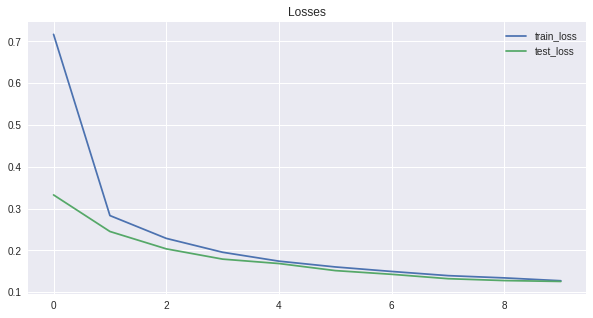

In [10]:
plot(train_losses, test_losses, "Losses", 'train_loss', 'test_loss', 'upper right')

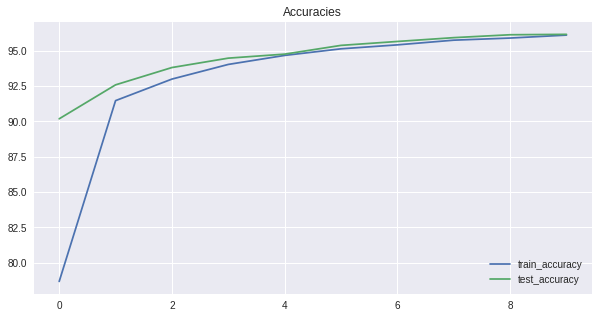

In [11]:
plot(train_accuracies, test_accuracies, "Accuracies", 'train_accuracy', 
     'test_accuracy', 'lower right')

Let's try using a network with a greater number of channels

In [12]:
(trained_model_100, train_accuracies, train_losses, test_accuracies, 
 test_losses) = run_model(CNN(hidden_channels=100), train_set, test_set, 10)

epoch 1: train_loss= 0.257, train_accuracy= 92.39, test_loss= 0.0835, test_accuracy= 97.58
epoch 2: train_loss= 0.0782, train_accuracy= 97.63, test_loss= 0.065, test_accuracy= 98.05
epoch 3: train_loss= 0.0597, train_accuracy= 98.16, test_loss= 0.047, test_accuracy= 98.56
epoch 4: train_loss= 0.0465, train_accuracy= 98.55, test_loss= 0.0319, test_accuracy= 99.07
epoch 5: train_loss= 0.0384, train_accuracy= 98.8, test_loss= 0.0283, test_accuracy= 99.1
epoch 6: train_loss= 0.0318, train_accuracy= 99.0, test_loss= 0.0258, test_accuracy= 99.15
epoch 7: train_loss= 0.0268, train_accuracy= 99.1, test_loss= 0.0297, test_accuracy= 99.0
epoch 8: train_loss= 0.0215, train_accuracy= 99.31, test_loss= 0.0153, test_accuracy= 99.55
epoch 9: train_loss= 0.0173, train_accuracy= 99.44, test_loss= 0.0115, test_accuracy= 99.65
epoch 10: train_loss= 0.0145, train_accuracy= 99.52, test_loss= 0.0123, test_accuracy= 99.63


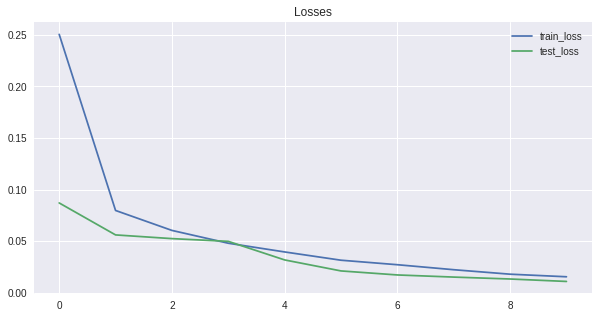

In [0]:
plot(train_losses, test_losses, "Losses", 'train_loss', 'test_loss', 'upper right')

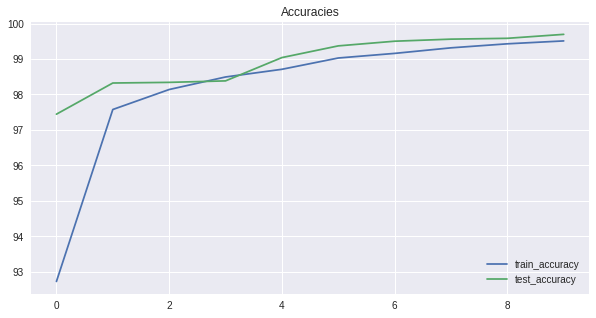

In [0]:
plot(train_accuracies, test_accuracies, "Accuracies", 'train_accuracy', 
     'test_accuracy', 'lower right')

Let's see how good this model is on some test set samples

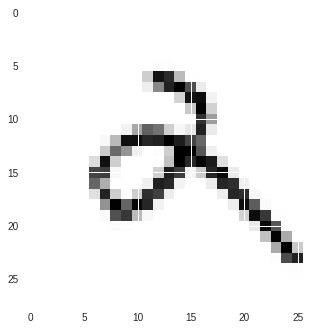

label:  tensor([2])
Model probabilities: [[0.    0.    0.996 0.003 0.    0.    0.    0.    0.    0.001]]
Model prediction:  tensor([2])


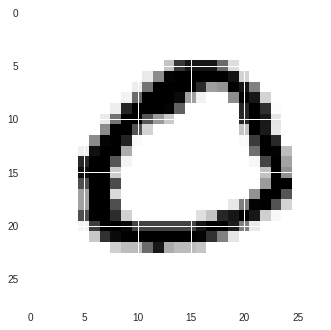

label:  tensor([0])
Model probabilities: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Model prediction:  tensor([0])


In [0]:
num_inputs = 2
batch_size = 1
test_set = DataLoader(test_mnist, batch_size=batch_size, shuffle=True)

for i, (test_image, test_label) in enumerate(test_set):
    if i == num_inputs:
          break
    plt.imshow(test_image[0][0])
    plt.show()
    print("label: ", test_label)
    out = trained_model_100(test_image)
    print("Model probabilities: {}".format(torch.exp(out).data.numpy().round(3)))
    print("Model prediction: ", out.max(-1)[1])